In [91]:
import matplotlib.pyplot as plt
import numpy as np

from common import NGSpiceRaw

%matplotlib widget

In [92]:
data = NGSpiceRaw("simulation/tgate_tb.raw", live=True)
print("Fields:", data.names)

Loaded 1 plots from simulation/tgate_tb.raw
Fields: ('time', 'v(ctrl)', 'v(vdd)', 'v(vss)', 'v(x1.ctrl_ni)', 'v(out)', 'v(x1.ctrl_i)', 'v(in)', 'v(x1.x2.net1)', 'i(vin1)', 'i(vss)', 'i(vdd)', 'i(vin)', 'v(n.x1.xm4.nsg13_lv_pmos#NOI)', 'v(n.x1.xm4.nsg13_lv_pmos#GP)', 'v(n.x1.xm4.nsg13_lv_pmos#SI)', 'v(n.x1.xm4.nsg13_lv_pmos#DI)', 'v(n.x1.xm4.nsg13_lv_pmos#BP)', 'v(n.x1.xm4.nsg13_lv_pmos#BI)', 'v(n.x1.xm4.nsg13_lv_pmos#BS)', 'v(n.x1.xm4.nsg13_lv_pmos#BD)', 'v(n.x1.xm4.nsg13_lv_pmos#INT1)', 'v(n.x1.xm4.nsg13_lv_pmos#INT2)', 'v(n.x1.xm4.nsg13_lv_pmos#INT3)', 'v(n.x1.xm4.nsg13_lv_pmos#INT4)', 'v(n.x1.xm4.nsg13_lv_pmos#INT5)', 'v(n.x1.xm4.nsg13_lv_pmos#INT6)', 'v(n.x1.xm4.nsg13_lv_pmos#INT7)', 'v(n.x1.xm4.nsg13_lv_pmos#INT8)', 'v(n.x1.xm4.nsg13_lv_pmos#INT9)', 'v(n.x1.xm4.nsg13_lv_pmos#flow(RES1))', 'v(n.x1.xm4.nsg13_lv_pmos#flow(SPLINE1))', 'v(n.x1.xm4.nsg13_lv_pmos#flow(RES2))', 'v(n.x1.xm4.nsg13_lv_pmos#flow(SPLINE2))', 'v(n.x1.xm4.nsg13_lv_pmos#flow(RES3))', 'v(n.x1.xm4.nsg13_lv_pmos#flo

In [93]:
F_SAMPLING = 40e6
F_SIGNAL = 234.375e3

In [94]:
times = data['time']
vin = data['v(in)']
vout = data['v(out)']

Loaded 1 plots from simulation/tgate_tb.raw
Loaded 1 plots from simulation/tgate_tb.raw
Loaded 1 plots from simulation/tgate_tb.raw


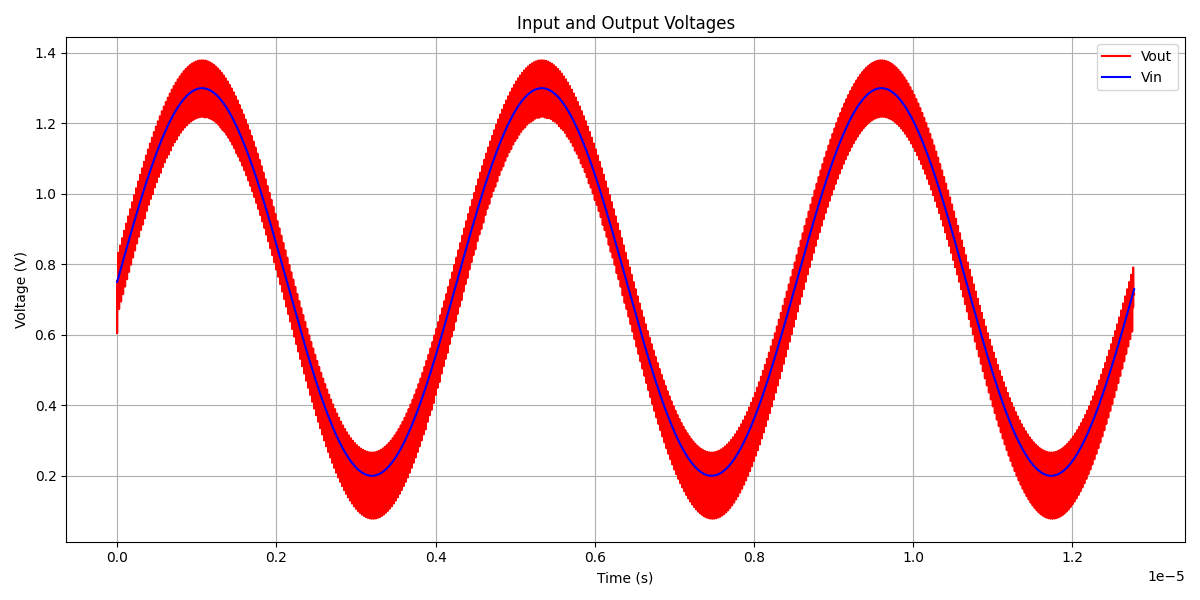

In [95]:
plt.figure(figsize=(12, 6))
plt.plot(times, vout, label='Vout', color='red')
plt.plot(times, vin, label='Vin', color='blue')
plt.title('Input and Output Voltages')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Number of samples: 512
Frequency bin size: 78125.0


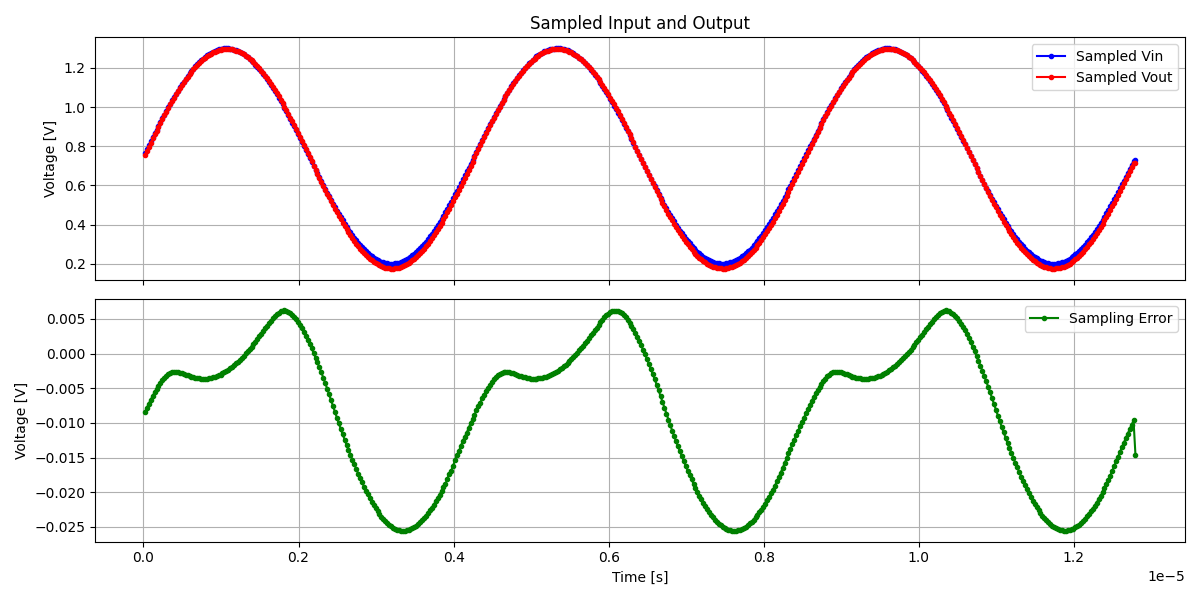

In [116]:
sampling_times = [0.75 / F_SAMPLING]
while sampling_times[-1] < times[-1]:
    sampling_times.append(sampling_times[-1] + 1 / F_SAMPLING)
# sampling_times = sampling_times[:-1]  # Remove the last time if it exceeds the signal duration

N = len(sampling_times)
f_bin = F_SAMPLING / N
print("Number of samples:", N)
print("Frequency bin size:", f_bin)

sampling_times = np.array(sampling_times)
sampling_vin = np.interp(sampling_times, times, vin)
sampling_vout = np.interp(sampling_times, times, vout)

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
# plt.plot(times, vout, label='Vout', color='red')
# plt.plot(times, vin, label='Vin', color='blue')
ax[0].plot(sampling_times, sampling_vin, label='Sampled Vin', color='blue', marker='o', markersize=3)
ax[0].plot(sampling_times, sampling_vout, label='Sampled Vout', color='red', marker='o', markersize=3)
ax[0].set_title('Sampled Input and Output')
ax[0].set_ylabel('Voltage [V]')
ax[0].grid()
ax[0].legend()
ax[1].plot(sampling_times, sampling_vout-sampling_vin, label='Sampling Error', color='green', marker='o', markersize=3)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Voltage [V]')
ax[1].grid()
ax[1].legend()
plt.tight_layout()
plt.show()

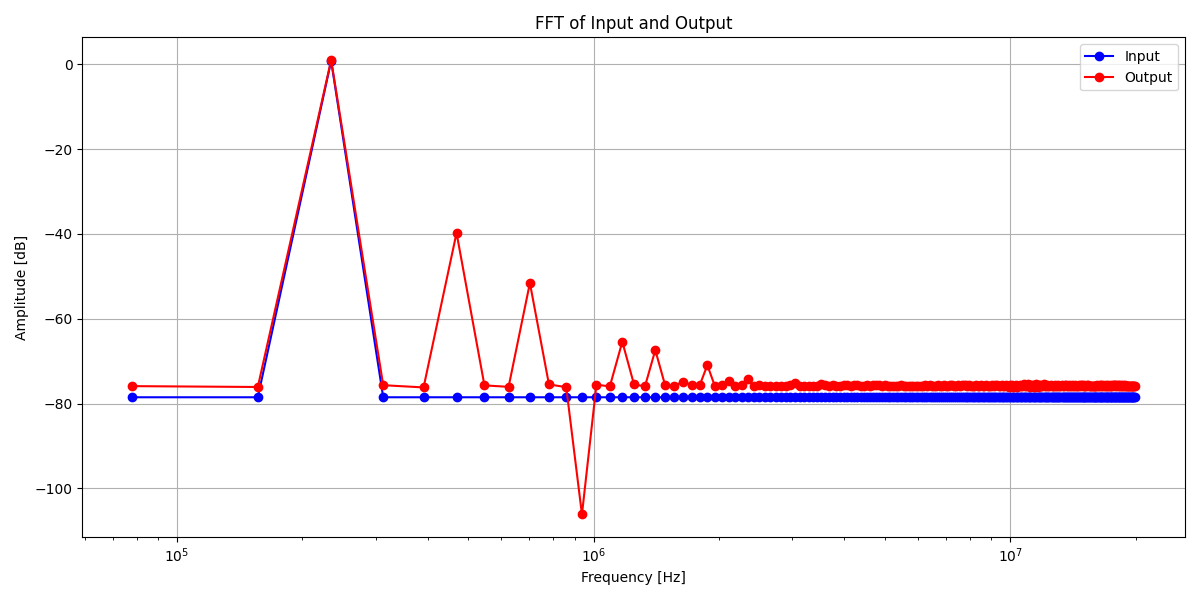

In [117]:
# FFT of input and output signals
N = len(sampling_vin)
T = 1 / F_SAMPLING

yf_vin = np.fft.fft(sampling_vin)
yf_vout = np.fft.fft(sampling_vout)
xf = np.fft.fftfreq(N, T)

yf_vin = 4.0 / N * np.abs(yf_vin[xf > 0])
yf_vout = 4.0 / N * np.abs(yf_vout[xf > 0])
xf = xf[xf > 0]

plt.figure(figsize=(12, 6))
plt.plot(xf, 20 * np.log10(yf_vin), 'o-', label='Input', color='blue')
plt.plot(xf, 20 * np.log10(yf_vout), 'o-', label='Output', color='red')
plt.title('FFT of Input and Output')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
# plt.xlim(0, 1.5 * F_SIGNAL)
plt.xscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [104]:
# Compute THD
def compute_thd(signal, fundamental_freq, sampling_rate):
    N = len(signal)
    T = 1 / sampling_rate
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, T)[:N // 2]
    
    # Find the index of the fundamental frequency
    fundamental_index = np.where(np.isclose(xf, fundamental_freq, atol=1e-3))[0]
    
    if len(fundamental_index) == 0:
        return None
    
    fundamental_index = fundamental_index[0]
    # print(f"Fundamental frequency index: {fundamental_index}")
    
    # Compute the total harmonic distortion (THD)
    fundamental_amplitude = np.abs(yf[fundamental_index])
    harmonics_amplitude = np.sum(np.abs(yf[2 * fundamental_index:]))
    
    thd = harmonics_amplitude / fundamental_amplitude
    return thd

thd_vin = compute_thd(sampling_vin, F_SIGNAL, F_SAMPLING)
thd_vout = compute_thd(sampling_vout, F_SIGNAL, F_SAMPLING)
print(f"THD Vin: {thd_vin}")
print(f"THD Vout: {thd_vout}")

# Compute SNR
def compute_snr(signal, fundamental_freq, sampling_rate):
    N = len(signal)
    T = 1 / sampling_rate
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, T)[:N // 2]
    
    # Find the index of the fundamental frequency
    fundamental_index = np.where(np.isclose(xf, fundamental_freq, atol=1e-3))[0]
    
    if len(fundamental_index) == 0:
        return None
    
    fundamental_index = fundamental_index[0]
    # print(f"Fundamental frequency index: {fundamental_index}")
    
    # Compute the signal power and noise power
    signal_power = np.abs(yf[fundamental_index]) ** 2
    noise_power = np.sum(np.abs(yf) ** 2) - signal_power
    
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

snr_vin = compute_snr(sampling_vin, F_SIGNAL, F_SAMPLING)
snr_vout = compute_snr(sampling_vout, F_SIGNAL, F_SAMPLING)
print(f"SNR Vin: {snr_vin} dB")
print(f"SNR Vout: {snr_vout} dB")

THD Vin: 1.0544520995874882
THD Vout: 1.0966932934034002
SNR Vin: -9.2620964132832 dB
SNR Vout: -9.004391889948925 dB
